## Setup a classification experiment

In [3]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

def rfecv_feats(X_train,y_train,folds,model):

    min_features_to_select = 1
    
    if model == "svc": model = SVC(kernel='linear')
    elif model == "lr": model = LogisticRegression(penalty='l2', solver='sag')
    elif model == "ebm": model = ExplainableBoostingClassifier(random_state=1, n_jobs=-1)

    rfecv = RFECV(estimator=model, step=0.05, cv=StratifiedKFold(folds),
                  scoring='roc_auc',
                  min_features_to_select=1)
    rfecv = rfecv.fit(X_train, y_train)

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(
        range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
        rfecv.grid_scores_,
    )
    plt.show()
        
    return X_train.iloc[:,rfecv.support_].columns.to_list()

In [2]:
from imblearn.over_sampling import SMOTE

In [307]:
X = pd.read_csv('Clinical validation.csv',index_col = 0)
y = X.loc[:,"dfsstatus"]

# X = X.loc[:,['histotype', 'histologicalgrade', 'ageatoperation', 'sizeoftumour',
#        'numoflymphnodesinv', 'avetils4', 'LVI', 'eic', 'multifocal', 'margin',
#        'contralaterbrca', 'boostpositive', 'her2amp', 'newmolsubtype',
#        'meanp1strCD20', 'meanp1strCD3', 'meanp1strCD68', 'meanp1strCD8',
#        'meanp2strCD3', 'meanp2strFoxP3', 'meanp2strPD1', 'meanp2strPDL1',
#        'chemoyn', 'chemo3', 'treat', 'meno', 'adjhorm', 'adjchem',
#        'mastectomy', 'contralateralbreastcancer', 'secondmalignancy',
#        'siteofsecondmalignancy', 'icdcodesecondcancer',
#        'locoregionalrecurrence', 'siteoflocoregionalrecurrence', 'ernucavg',
#        'ernucavgint', 'prnucavg', 'prnucavgint', 'her2amp.1', 'Ki67Avg%']]

X.columns

Index(['histotype', 'histologicalgrade', 'ageatoperation', 'sizeoftumour',
       'numoflymphnodesinv', 'avetils4', 'LVI', 'eic', 'multifocal', 'margin',
       'adjhormones', 'adjchemo', 'contralaterbrca', 'boostpositive',
       'her2amp', 'newmolsubtype', 'meanp1strCD20', 'meanp1strCD3',
       'meanp1strCD68', 'meanp1strCD8', 'meanp2strCD3', 'meanp2strFoxP3',
       'meanp2strPD1', 'meanp2strPDL1', 'chemo', 'chemo3', 'chemoyn', 'treat',
       'meno', 'datesurg', 'adjhorm', 'datehorm', 'adjchem', 'datechem',
       'dateh', 'datechemo', 'date', 'breaststatus', 'distantstatus',
       'patientstatus', 'psdate', 'cdspecify', 'datefu', 'datelast',
       'dateofsurgery', 'death', 'dateofdeath', 'causeofdeath',
       'ifothercancer', 'ifnoncancer', 'icdcodedeath', 'localrecurrence',
       'dateoflr', 'mastectomy', 'dateofmastectomy',
       'contralateralbreastcancer', 'dateofcbc', 'secondmalignancy',
       'dateofsecondmalignancy', 'siteofsecondmalignancy',
       'icdcodesecondcan

In [1]:
import pandas as pd
from feature_selector import FeatureSelector
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X = pd.read_csv('Clinical validation.csv', index_col = 0)
y = X.loc[:,"deathstatus"]

# Get ER patients
X = X.loc[X['newmolsubtype'].str.contains("Luminal")]
X = X.loc[X['adjhorm'] == 2]
X = X.loc[X['meno'] == 2]
y = y.loc[(X['newmolsubtype'].str.contains("Luminal") == True).index]
y = y.loc[(X['adjhorm'] == 2).index]
y = y.loc[(X['meno'] == 2).index]

# Match validation features to current data features
#['age at diagnosis', 'BMI kg/m2', 'Q pre Rx Ki67', 'Grade ', 'Size',
#       'nodes', 'total_nodes', 'Post Rx TILs %', 'Pre Rx ER Percent',
#       'Pre Rx ER', 'Pre Rx PR Percent', 'Pre Rx PR', 'Pre Rx HER2']

# X = X.loc[:,["ageatoperation",'Ki67Avg%','histologicalgrade','sizeoftumour',"numoflymphnodesinv","avetils4","ernucavg",
#             "ernucavgint","prnucavg","prnucavgint","her2amp.1"]]

X = X.loc[:,["Ki67Avg%","histologicalgrade","sizeoftumour","numoflymphnodesinv","avetils4"]]

# NA value
# 1. Size of tumour missing for patient 20197
# 2. Histologicalgrade unknown for patient 20388

X = X.drop([20197])
y = y.drop([20197])

X.loc[:,"histologicalgrade"] = X.loc[:,"histologicalgrade"].map({'2 - Medium': 2, '1 - Low': 1, "3 - High": 3}).astype(int)

#X.loc[:,"her2amp.1"] = X.loc[:,"her2amp.1"].map({"N": 0, "Y":1}).astype(int)
print(y.value_counts())

0    94
1    70
Name: deathstatus, dtype: int64


In [448]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

under = SMOTE()
X_under, y_under = under.fit_resample(X,y)
y_under.value_counts()

0    151
1    151
Name: brdeathstatus, dtype: int64

In [449]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=y)
fig.show()

In [450]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

def oob_rf_params(X,y):

    RANDOM_STATE = 123

    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    ensemble_clfs = [
        (
            "RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(
                warm_start=True,
                oob_score=True,
                max_features="sqrt",
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(
                warm_start=True,
                max_features="log2",
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features=None",
            RandomForestClassifier(
                warm_start=True,
                max_features=None,
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = 500

    min_oob_error = 1

    j = 0
    sqrt_error = []
    log2_error = []
    none_error = []
    
    for label, clf in ensemble_clfs:
        
        errors = [sqrt_error,log2_error,none_error]
        
        for i in range(min_estimators, max_estimators + 1, 5):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            
            errors[j].append(oob_error)
            if oob_error < min_oob_error: 
                min_oob_error = oob_error
                best_estimators = i
                clf_best = str(clf[0])

            error_rate[label].append((i, oob_error))
        
        j += 1
        
    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

    return min_oob_error, best_estimators, clf_best, errors

In [451]:
from imblearn.combine import SMOTETomek

In [452]:
y.value_counts()

0    151
1     13
Name: brdeathstatus, dtype: int64

k-fold:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

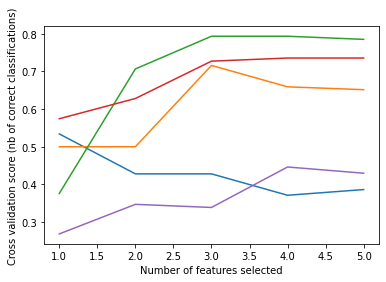

k-fold:   2%|█▌                                                                          | 1/50 [00:00<00:15,  3.08it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'avetils4']


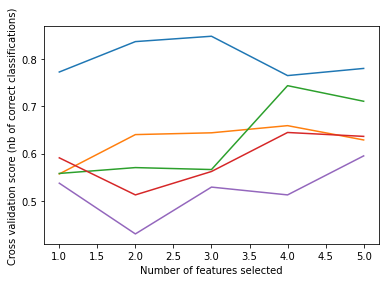

k-fold:   4%|███                                                                         | 2/50 [00:00<00:14,  3.41it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


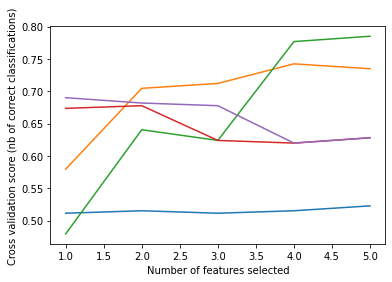

k-fold:   6%|████▌                                                                       | 3/50 [00:01<00:16,  2.83it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


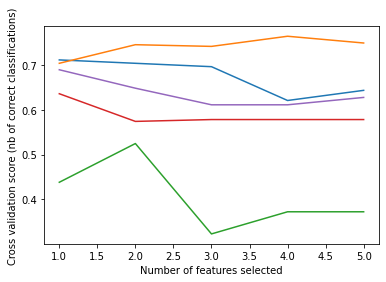

k-fold:   8%|██████                                                                      | 4/50 [00:01<00:15,  3.00it/s]

['numoflymphnodesinv', 'avetils4']


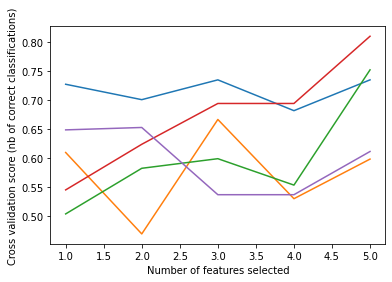

k-fold:  10%|███████▌                                                                    | 5/50 [00:01<00:14,  3.05it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


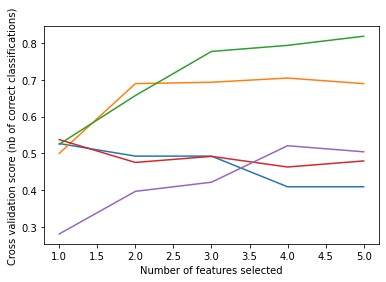

k-fold:  12%|█████████                                                                   | 6/50 [00:01<00:13,  3.14it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


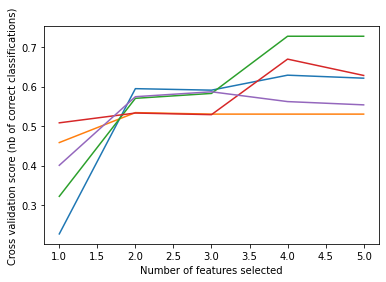

k-fold:  14%|██████████▋                                                                 | 7/50 [00:02<00:15,  2.73it/s]

['histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


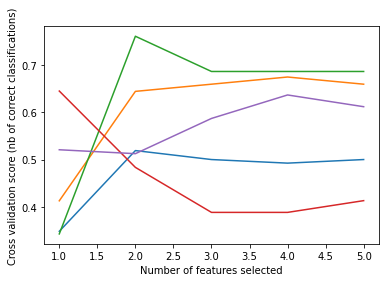

k-fold:  16%|████████████▏                                                               | 8/50 [00:02<00:14,  2.85it/s]

['histologicalgrade', 'avetils4']


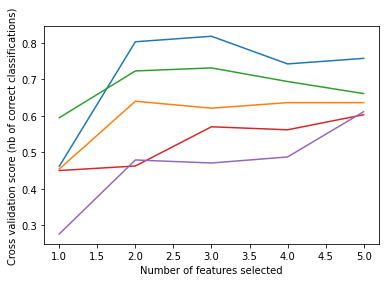

k-fold:  18%|█████████████▋                                                              | 9/50 [00:03<00:14,  2.82it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


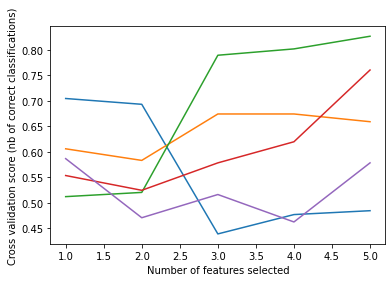

k-fold:  20%|███████████████                                                            | 10/50 [00:03<00:13,  3.00it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


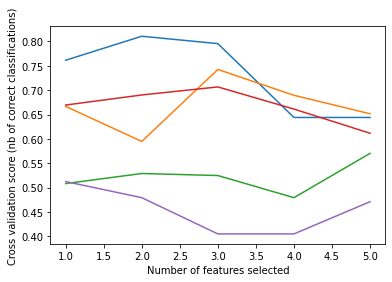

k-fold:  22%|████████████████▌                                                          | 11/50 [00:03<00:12,  3.07it/s]

['histologicalgrade', 'numoflymphnodesinv', 'avetils4']


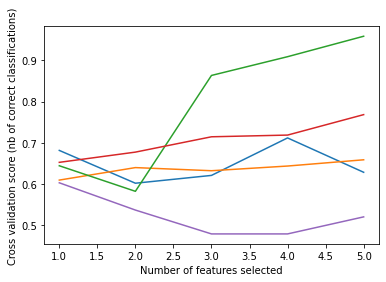

k-fold:  24%|██████████████████                                                         | 12/50 [00:03<00:12,  3.12it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


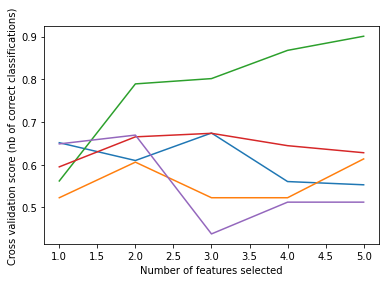

k-fold:  26%|███████████████████▌                                                       | 13/50 [00:04<00:12,  2.89it/s]

['histologicalgrade', 'numoflymphnodesinv']


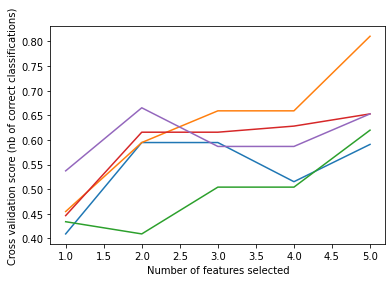

k-fold:  28%|█████████████████████                                                      | 14/50 [00:04<00:11,  3.01it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


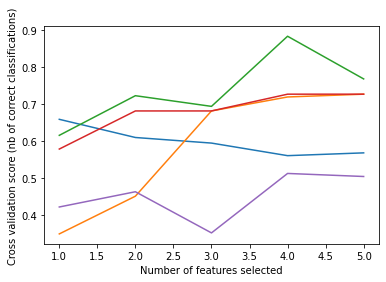

k-fold:  30%|██████████████████████▌                                                    | 15/50 [00:04<00:11,  3.18it/s]

['histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


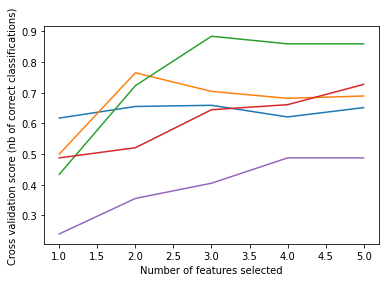

k-fold:  32%|████████████████████████                                                   | 16/50 [00:05<00:11,  3.06it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


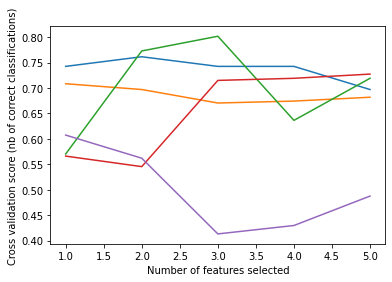

k-fold:  34%|█████████████████████████▌                                                 | 17/50 [00:05<00:10,  3.22it/s]

['histologicalgrade', 'numoflymphnodesinv', 'avetils4']


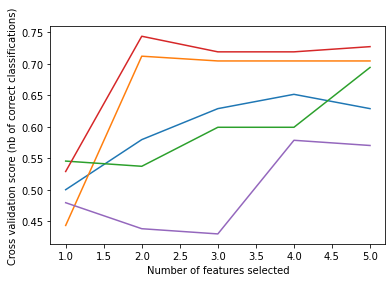

k-fold:  36%|███████████████████████████                                                | 18/50 [00:05<00:09,  3.32it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


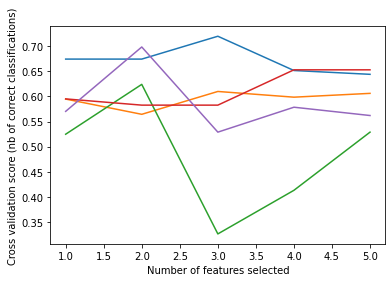

k-fold:  38%|████████████████████████████▌                                              | 19/50 [00:06<00:09,  3.39it/s]

['numoflymphnodesinv', 'avetils4']


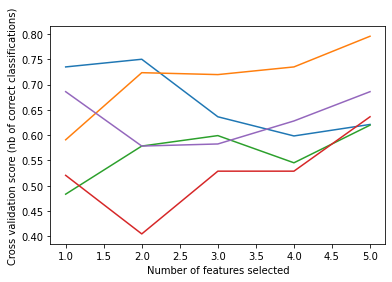

k-fold:  40%|██████████████████████████████                                             | 20/50 [00:06<00:11,  2.71it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


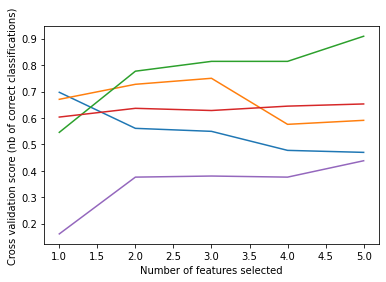

k-fold:  42%|███████████████████████████████▌                                           | 21/50 [00:06<00:09,  2.91it/s]

['histologicalgrade', 'numoflymphnodesinv', 'avetils4']


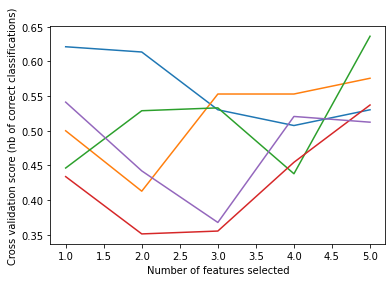

k-fold:  44%|█████████████████████████████████                                          | 22/50 [00:07<00:09,  2.90it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


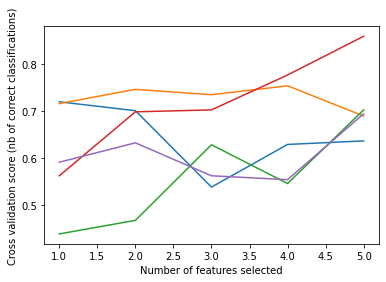

k-fold:  46%|██████████████████████████████████▌                                        | 23/50 [00:07<00:08,  3.20it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


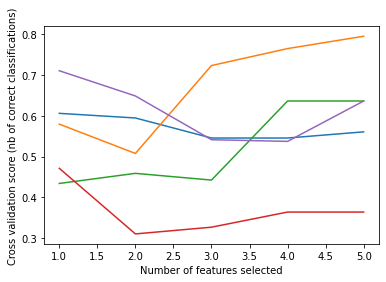

k-fold:  48%|████████████████████████████████████                                       | 24/50 [00:07<00:07,  3.37it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


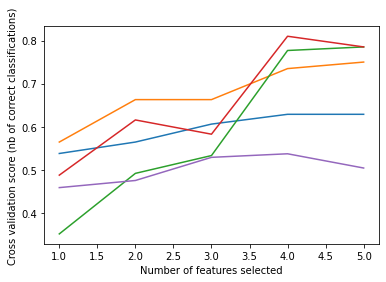

k-fold:  50%|█████████████████████████████████████▌                                     | 25/50 [00:08<00:07,  3.25it/s]

['histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


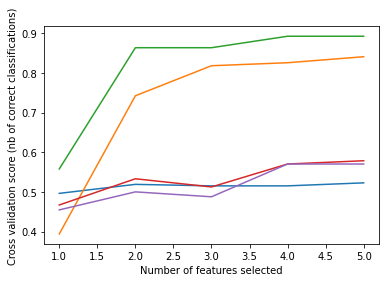

k-fold:  52%|███████████████████████████████████████                                    | 26/50 [00:08<00:07,  3.12it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


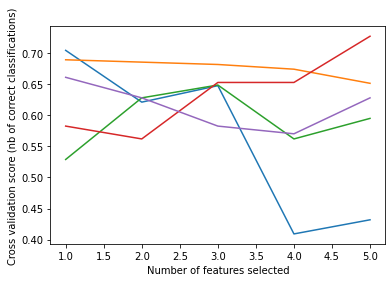

k-fold:  54%|████████████████████████████████████████▌                                  | 27/50 [00:08<00:07,  3.19it/s]

['histologicalgrade', 'numoflymphnodesinv', 'avetils4']


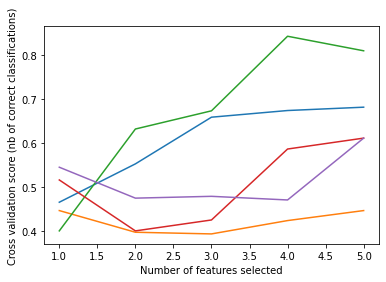

k-fold:  56%|██████████████████████████████████████████                                 | 28/50 [00:09<00:06,  3.36it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


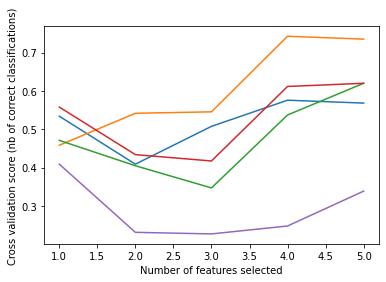

k-fold:  58%|███████████████████████████████████████████▌                               | 29/50 [00:09<00:05,  3.50it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


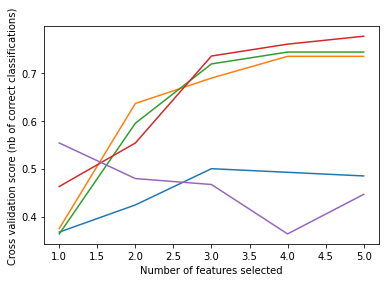

k-fold:  60%|█████████████████████████████████████████████                              | 30/50 [00:09<00:05,  3.64it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


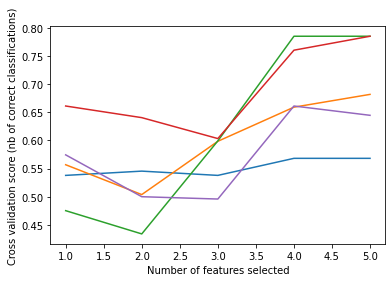

k-fold:  62%|██████████████████████████████████████████████▌                            | 31/50 [00:10<00:06,  2.99it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


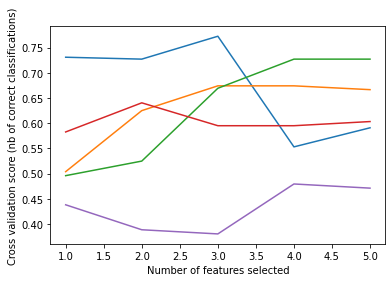

k-fold:  64%|████████████████████████████████████████████████                           | 32/50 [00:10<00:06,  2.90it/s]

['histologicalgrade', 'sizeoftumour', 'avetils4']


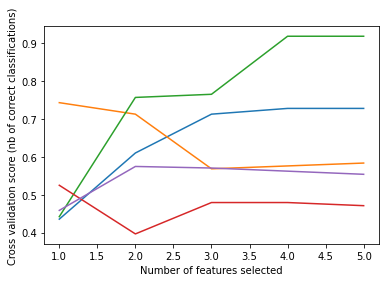

k-fold:  66%|█████████████████████████████████████████████████▌                         | 33/50 [00:10<00:06,  2.83it/s]

['histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


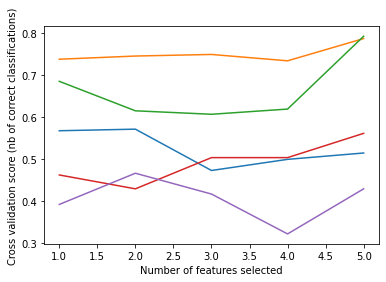

k-fold:  68%|███████████████████████████████████████████████████                        | 34/50 [00:11<00:05,  3.06it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


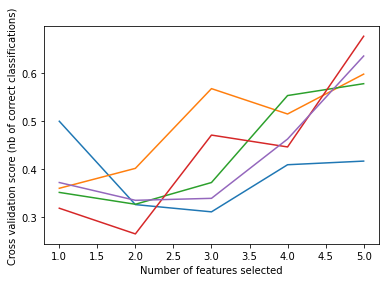

k-fold:  70%|████████████████████████████████████████████████████▌                      | 35/50 [00:11<00:04,  3.27it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


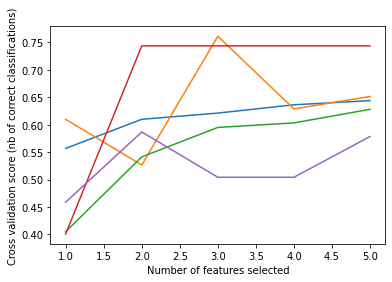

k-fold:  72%|██████████████████████████████████████████████████████                     | 36/50 [00:11<00:04,  3.20it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


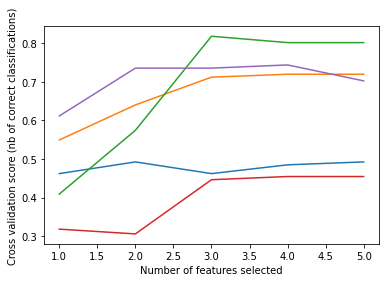

k-fold:  74%|███████████████████████████████████████████████████████▌                   | 37/50 [00:11<00:03,  3.27it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'avetils4']


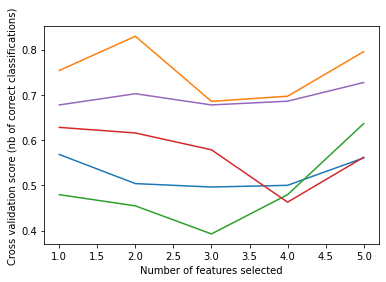

k-fold:  76%|█████████████████████████████████████████████████████████                  | 38/50 [00:12<00:03,  3.30it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


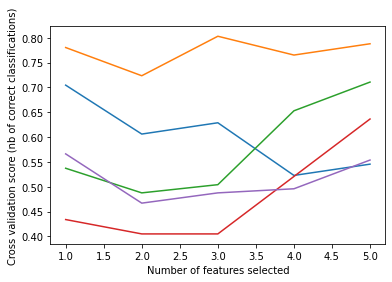

k-fold:  78%|██████████████████████████████████████████████████████████▌                | 39/50 [00:12<00:03,  3.39it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


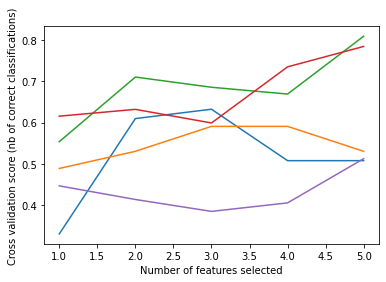

k-fold:  80%|████████████████████████████████████████████████████████████               | 40/50 [00:12<00:02,  3.46it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


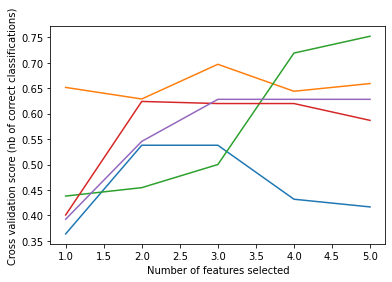

k-fold:  82%|█████████████████████████████████████████████████████████████▍             | 41/50 [00:13<00:02,  3.54it/s]

['histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


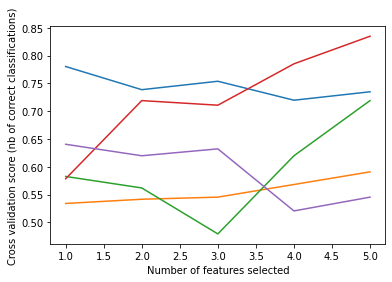

k-fold:  84%|███████████████████████████████████████████████████████████████            | 42/50 [00:13<00:02,  2.89it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


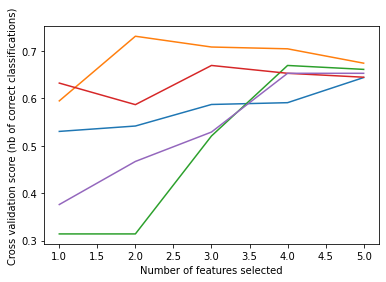

k-fold:  86%|████████████████████████████████████████████████████████████████▌          | 43/50 [00:13<00:02,  3.15it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


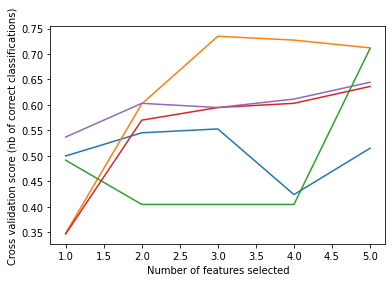

k-fold:  88%|██████████████████████████████████████████████████████████████████         | 44/50 [00:14<00:02,  2.32it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


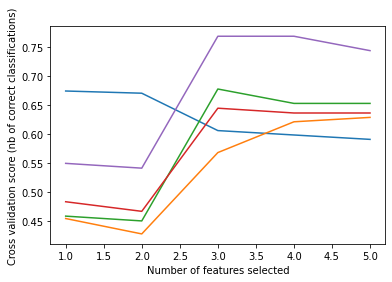

k-fold:  90%|███████████████████████████████████████████████████████████████████▌       | 45/50 [00:14<00:02,  2.37it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'avetils4']


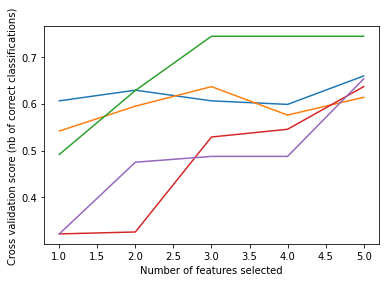

k-fold:  92%|█████████████████████████████████████████████████████████████████████      | 46/50 [00:15<00:01,  2.45it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


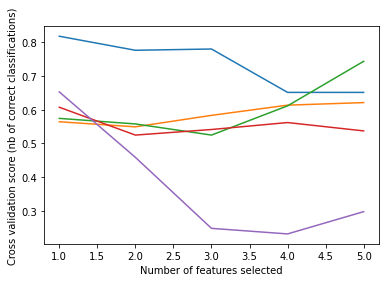

k-fold:  94%|██████████████████████████████████████████████████████████████████████▌    | 47/50 [00:15<00:01,  2.64it/s]

['numoflymphnodesinv']


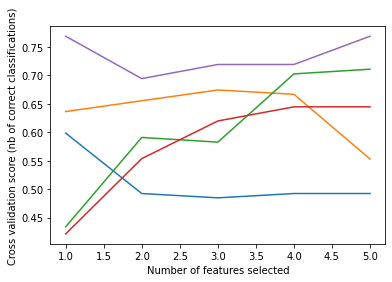

k-fold:  96%|████████████████████████████████████████████████████████████████████████   | 48/50 [00:15<00:00,  2.80it/s]

['Ki67Avg%', 'histologicalgrade', 'numoflymphnodesinv', 'avetils4']


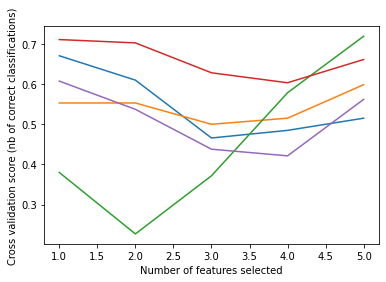

k-fold:  98%|█████████████████████████████████████████████████████████████████████████▌ | 49/50 [00:16<00:00,  2.93it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


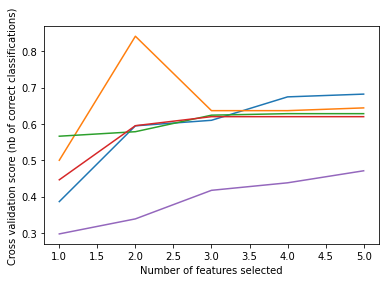

k-fold: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]

['Ki67Avg%', 'histologicalgrade', 'sizeoftumour', 'numoflymphnodesinv', 'avetils4']


In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import RocCurveDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from math import floor
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.svm import SVC
warnings.filterwarnings(action='ignore')

from imblearn.under_sampling import RandomUnderSampler

#X = X_under
#y = y_under

seed = 1

folds = 5

kfold = RepeatedStratifiedKFold(n_splits=folds, n_repeats=10, random_state=seed)

clinical_scores = np.zeros((X.shape[0],10))

i = 0

X = pd.get_dummies(X, prefix_sep='.')
#feature_names = list(X_enc.columns)

for train_index, test_index in tqdm(kfold.split(X, y), total=kfold.get_n_splits(), desc="k-fold"):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #features = rfecv_feats(X_train,y_train,5,"lr")
    
#     print(features)
    
#     X_train = X_train.loc[:,features]
#     X_test = X_test.loc[:,features]
    
#     model = SVC(probability=True, kernel="sigmoid")
#     model.fit(X_train,y_train)
    
    #sampling = SMOTETomek()
    #X_over, y_over = sampling.fit_resample(X_train,y_train)
    
    sampling = RandomUnderSampler()
    X_over, y_over = sampling.fit_resample(X_train,y_train)
    
    features = rfecv_feats(X_over,y_over,5,"lr")
    
    print(features)
    
    X_over = X_over.loc[:,features]
    X_test = X_test.loc[:,features]
    
    model = LogisticRegression(penalty='l2', solver='sag')
    #model = SVC(probability=True, kernel="sigmoid")
    model.fit(X_over,y_over)
    
    for pred,label in zip(model.predict_proba(X_test),test_index):
        clinical_scores[label][floor(i/folds)] = pred[1]
    
    #for a, b in zip(model.predict_proba(X_test), y_test):
    #    print("Prediction: "+str(a)+" Real: "+str(b)+"\n")
    i += 1

In [5]:
def listify(p):
    y_list = []
    for val in p: y_list.append([val])
    return y_list

In [6]:
mean = np.mean(clinical_scores, axis=1)
    
labelled_scores = np.append(clinical_scores, listify(mean), axis=1)
labelled_scores_mean = np.append(labelled_scores, listify(y), axis = 1)

<AxesSubplot:>

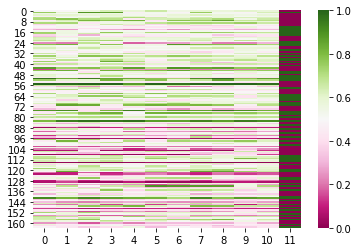

In [7]:
import seaborn as sns

sns.heatmap(labelled_scores_mean,cmap="PiYG")

0.5792682926829268
[[47 22]
 [47 48]]


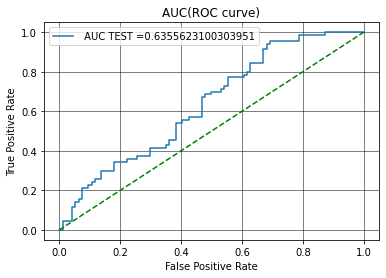

In [8]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y,labelled_scores_mean[:,-2])

plt.grid()

acc = []
for val in labelled_scores_mean[:,-2]:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y, acc))
print(confusion_matrix(acc, y, labels = [0,1]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [9]:
def occ(scores,thresh):
    
    occ = []

    for row in scores[:,:-2]:
        k = 0
        for item in row:
            if item >= thresh: k+=1
            
        occ.append(k/10)
        
    return occ

In [10]:
occ_clinical = occ(labelled_scores_mean,0.5)

In [11]:
164*0.817

133.988

In [12]:
from sklearn.metrics import roc_curve, auc
import plotly.express as px

acc = []
for val in occ_clinical:
    acc.append(0) if val < 0.5 else acc.append(1)
    
print(accuracy_score(y, acc))
print(confusion_matrix(acc, y, labels = [0,1]))

fpr, tpr, thresholds = roc_curve(y, occ_clinical)

fig = px.area(
    x=fpr, y=tpr,
    title=f'Clinical Pre Treatment ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

0.5853658536585366
[[47 21]
 [47 49]]


In [18]:
from sklearn import svm
import shap
svm_explainer = shap.KernelExplainer(model.predict,X)
svm_shap_values = svm_explainer.shap_values(X)

Using 188 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/188 [00:00<?, ?it/s]

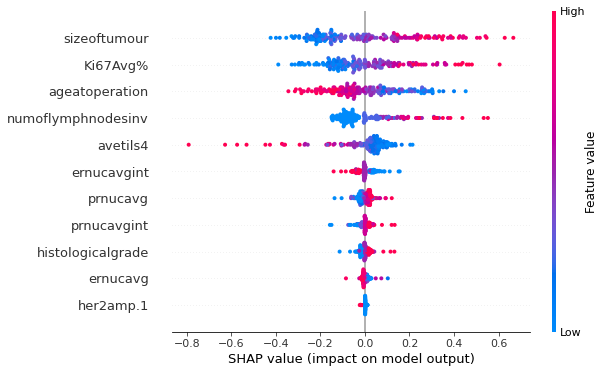

In [53]:
shap.summary_plot(svm_shap_values, X)

[0.15618429 0.13810494 0.2216837  0.03615442 0.14322914 0.02408497
 0.05159578 0.22896276]


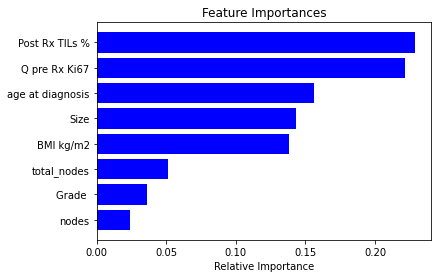

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

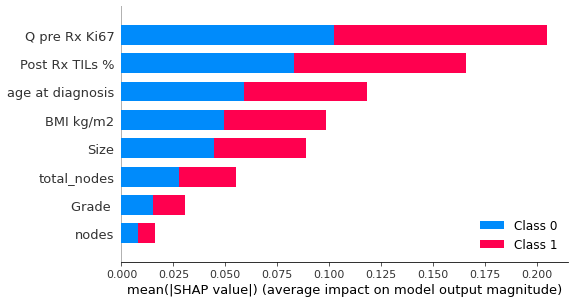

In [67]:
import shap

shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

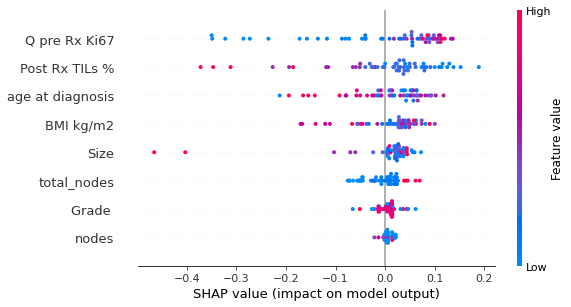

In [68]:
shap.summary_plot(shap_values[1], X_train, plot_type="dot")

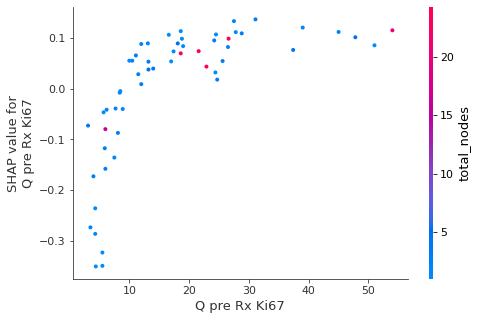

In [69]:
shap.dependence_plot("Q pre Rx Ki67", shap_values[1], X_train)

In [82]:
shap.initjs()
rf_explainer = shap.KernelExplainer(rf.predict, X_train)
rf_shap_values = rf_explainer.shap_values(X_train)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/56 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

In [85]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values[-1,:], X_train.iloc[-1,:])

In [86]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X_train)